In [1]:
%pylab inline
import pickle
from sklearn.cluster import KMeans
from sklearn import preprocessing
import numpy as np
from astropy.table import QTable, Table, Column

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
path = '/bgfs/akosowsky/yig20/shared/pickle_files/pa5_f090_s19_c11_v0_results.pickle'
with open(path, 'rb') as f:
    data = pickle.load(f, encoding = 'latin1')
data.keys()

dict_keys(['name', 'scan_freq', 'sel', 'psel', 'resp', 'resp_sel', 'cal', 'ctime', 'alt', 'pwv', 'tod_sel', 'gainLive', 'gainLive_sel', 'corrLive', 'corrLive_sel', 'normLive', 'normLive_sel', 'rmsLive', 'rmsLive_sel', 'kurtLive', 'kurtLive_sel', 'skewLive', 'skewLive_sel', 'MFELive', 'MFELive_sel', 'DELive', 'DELive_sel', 'jumpLive', 'jumpLive_sel', 'live', 'dark', 'ff', 'ff_sel', 'stable', 'tes_sel'])

In [4]:
features_list = ['gainLive', 'rmsLive', 'kurtLive', 'normLive', 'skewLive', 'MFELive', 'DELive','corrLive','jumpLive']

# number of dets
ndets = data['gainLive'].shape[0]

# tod selection: choose three tods
tod_sel = np.array([0,2300,4600,13800,6900])
# need to have another array that tells me which TOD i'm look at
# it looks like [0,0,...,0,2300,2300,...,2300]
tod_id = np.repeat(tod_sel, ndets)
# need to have another array that tells me the detector id for each data
# it looks like [0,1,2,...,...3519]
det_id = np.arange(ndets*len(tod_sel))
# stack the features
features = np.hstack([data[feat][:,tod_sel].reshape(-1,1, order = 'F') for feat in features_list])
# get final detector cuts (sel)
sel = np.hstack([data['sel'][:,i] for i in tod_sel])
# mask a mask for sel == 1 (good detectors)
mask_good = (sel == 1)

# make a mask for valid gains (first column in features)
mask_valid = np.hstack([data['gainLive'][:,i] !=0 for i in tod_sel])

# restrict to gain !=0 only
features1 = features[mask_valid,:]
# use log for jump
features1[:,-1] = np.log(features1[:,-1])
#print(stand_features.dtype)
scaler = StandardScaler()
scaled_features = scaler.fit(features1)
##trying to save the scaler so I dont have to use code like below
fitted_data = (scaler.fit_transform(features1))
#stand_features = preprocessing.scale(features1, axis=0)

In [5]:
print(scaler.fit_transform(features1))

[[-0.09296503  1.12089133 -0.02527039 ...  0.07386196  0.24050286
   0.99150572]
 [-0.10978991  1.44096941 -0.32983897 ...  0.07542669  0.23828055
   0.75940015]
 [-0.08601828  1.63539646 -0.30870693 ...  0.00828879  0.24232313
   1.26636088]
 ...
 [-0.06448497 -0.67858076 -0.45905529 ... -0.16608638  0.1575896
  -0.73995462]
 [-0.03649839 -0.57237506 -0.65564699 ... -0.16616399  0.17221077
  -0.65891919]
 [ 0.11547307 -0.77548915 -0.43463329 ... -0.16408427 -0.02316027
  -0.88543057]]


In [6]:
# choose number of clusters
n_clusters = 9

kmean_stand = KMeans(n_clusters=n_clusters,n_init=500, max_iter=10000,tol=.0001, algorithm = 'full')
kmean_stand.fit(scaler.fit_transform(features1))

pred = kmean_stand.predict(scaler.fit_transform(features1))
centers = kmean_stand.cluster_centers_

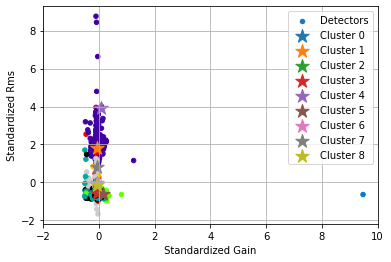

In [7]:

plt.scatter(fitted_data[:,0], fitted_data[:,1], s=20, c=pred, label = 'Detectors', cmap='nipy_spectral')
for i in range(n_clusters):
    plt.scatter(centers[i, 0], centers[i, 1], s = 200, label = f'Cluster {i}', marker = '*')
plt.xlabel(" Standardized Gain ")
plt.ylabel(" Standardized Rms ")
plt.xlim(-2,10)
plt.legend()
plt.grid()
plt.show()



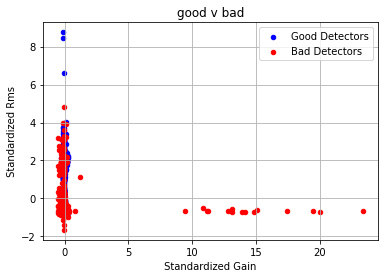

In [8]:
good = mask_good[mask_valid]

plt.scatter(fitted_data[:,0][good], fitted_data[:,1][good], s=20, c='b', label = 'Good Detectors')
plt.scatter(fitted_data[:,0][~good], fitted_data[:,1][~good], s=20, c='r', label = 'Bad Detectors')
plt.xlabel(" Standardized Gain ")
plt.ylabel(" Standardized Rms ")
plt.title('good v bad')
plt.legend()
plt.grid()
plt.show()

In [9]:
def load_tod_data(tod_list, ds=10):
    # here the tod list is to be replaced with your list of tod names
    # such as ['/bgfs/akosowsky/yig20/shared/pickle_files/1551491060.1551501304.ar5.pkl',...]
    # they need to be in the right order that's compatible with good / bad mask
    # here ds means downsample factor in time stream
    datas = []
    for todname in tod_list:
        with open(todname, "rb") as f:
            tmp = pickle.load(f, encoding='latin1')['data']
        datas.append(tmp[:,::ds])
        del tmp
    # stacked them accordingly
    minl = min([d.shape[-1] for d in datas])
    datas = np.vstack([d[:,:minl] for d in datas])
    return datas

In [10]:
##using this to find the name for the tod order

data['name'][6900]

'1559791186.1559801171.ar5'

In [11]:
TODS = np.array(['/bgfs/akosowsky/yig20/shared/pickle_files/1551491060.1551501304.ar5.pkl',
                '/bgfs/akosowsky/yig20/shared/pickle_files/1553201737.1553211922.ar5.pkl',
                '/bgfs/akosowsky/yig20/shared/pickle_files/1555590950.1555601987.ar5.pkl',
                '/bgfs/akosowsky/yig20/shared/pickle_files/1564964420.1564973790.ar5.pkl',
                '/bgfs/akosowsky/yig20/shared/pickle_files/1559791186.1559801171.ar5.pkl'])
'''

TODS = np.array(['/bgfs/akosowsky/yig20/shared/pickle_files/1559791186.1559801171.ar5.pkl',
               '/bgfs/akosowsky/yig20/shared/pickle_files/1562165331.1562175449.ar5.pkl',
                '/bgfs/akosowsky/yig20/shared/pickle_files/1563541466.1563551634.ar5.pkl'])
'''

"\n\nTODS = np.array(['/bgfs/akosowsky/yig20/shared/pickle_files/1559791186.1559801171.ar5.pkl',\n               '/bgfs/akosowsky/yig20/shared/pickle_files/1562165331.1562175449.ar5.pkl',\n                '/bgfs/akosowsky/yig20/shared/pickle_files/1563541466.1563551634.ar5.pkl'])\n"

In [12]:
stacked_tods = load_tod_data(TODS)


#cali1 = cal[:,0][:,None]
#cali2 = cal[:,2300][:,None]
#cali3 = cal[:,4600][:,None]
#cali4 = cal[:,13800][:,None]
cali = np.vstack([data['cal'][:,i].reshape(-1,1, order = 'F') for i in tod_sel])
stacked_tods -= stacked_tods.mean(axis=1)[:,None]
stacked_tods *= cali

In [13]:
cali.shape

(8800, 1)

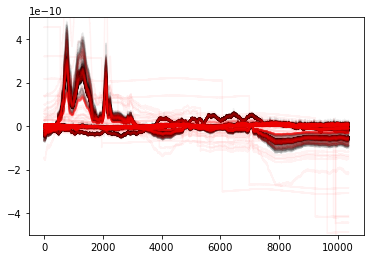

In [27]:
good = mask_good * mask_valid
bad  = (~mask_good) * mask_valid
plt.plot(stacked_tods[good].T, c='k', alpha=0.05)
plt.plot(stacked_tods[bad].T, c='r', alpha=0.05)
plt.ylim(-5e-10,5e-10)
plt.show()

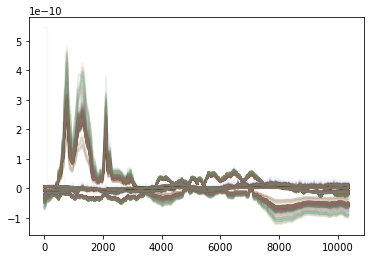

In [15]:
plt.plot(stacked_tods[sel==1].T, alpha=0.05)
plt.show()

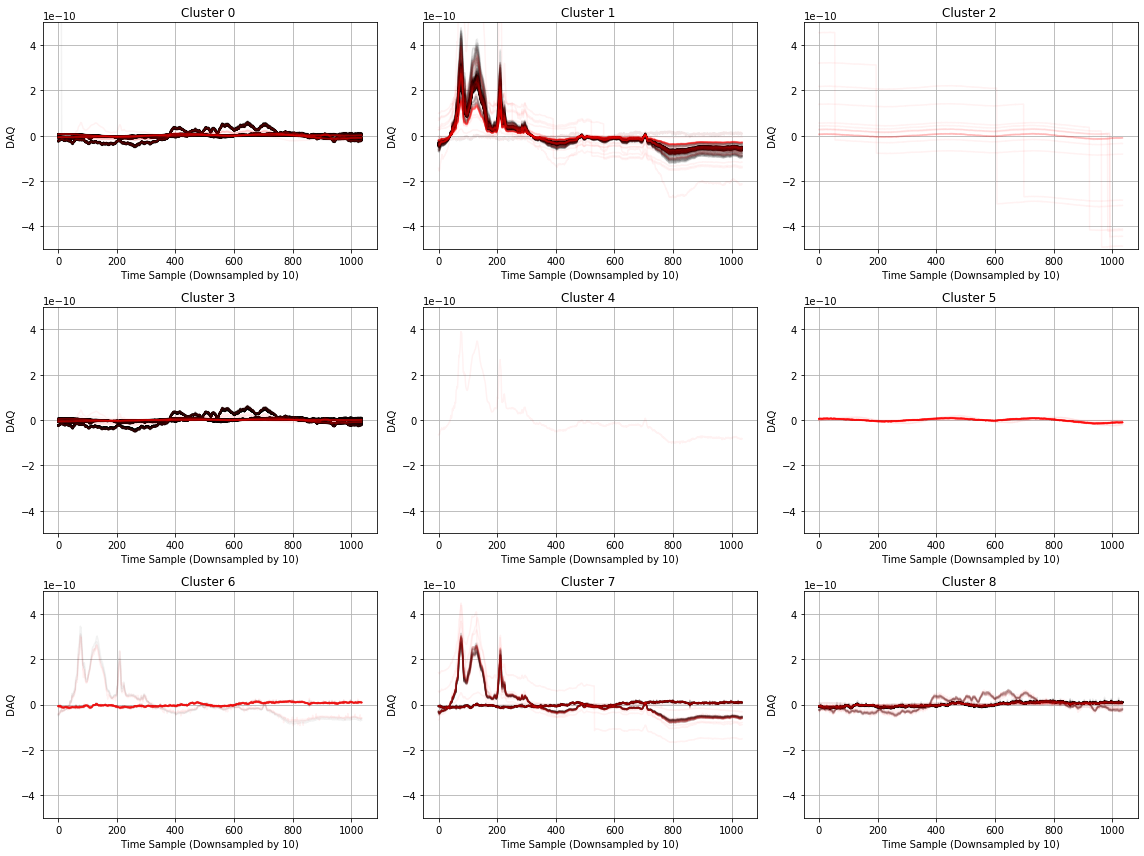

In [16]:
ncol = 3
nrow = int(np.ceil(n_clusters / 3)) 
plt.figure(figsize=(16,12))
for i in range(n_clusters):
    plt.subplot(nrow, ncol, i+1)
    # get the mask representing this cluster
    mask_pred = pred == i
    # get valid detectors
    det_valid = det_id[mask_valid]
    # get good detector mask (and valid)
    mask_sel = mask_good[mask_valid]
    good_ = det_valid[(mask_pred * mask_sel)]
    bad_ = det_valid[(mask_pred * (~mask_sel))]
    if len(good_) > 0: plt.plot(stacked_tods[good_, ::10].T, c='k', alpha=.05)
    if len(bad_) > 0: plt.plot(stacked_tods[bad_, ::10].T, c='r', alpha=.05)
    plt.ylim(-.5e-9,.5e-9)
    plt.grid()
    plt.ylabel(" DAQ ")
    plt.xlabel(" Time Sample (Downsampled by 10) ")
    plt.title(f"Cluster {i} ")
#plt.legend()
plt.tight_layout()
plt.show()

In [17]:
sel_list=[]
det_list=[]
bad_list=[]


for i in range(n_clusters):
    sel=np.sum(pred[mask_sel]==i)
    sel_list.append(sel)
    
    det=np.sum(pred==i)
    det_list.append(det)
    
    bad=np.sum(pred==i)-np.sum(pred[mask_sel]==i)
    bad_list.append(bad)
cluster = np.arange(9)
Sel = np.array(sel_list)
Det = np.array(det_list)
Bad = np.array(bad_list)

percent = np.array((Sel/Det)*100)
percent = np.round(percent, 2)
t = Table([cluster,Det,Sel,Bad,percent], names =( 'Cluster Number', 'Amount of Detectors','Amount of Good Detectors','Amount of Bad Detectors','Percent of Good Detectors'))

In [18]:
t

Cluster Number,Amount of Detectors,Amount of Good Detectors,Amount of Bad Detectors,Percent of Good Detectors
int64,int64,int64,int64,float64
0,1059,1002,57,94.62
1,633,558,75,88.15
2,15,0,15,0.0
3,1119,1070,49,95.62
4,1,0,1,0.0
5,52,0,52,0.0
6,46,4,42,8.7
7,139,104,35,74.82
8,415,387,28,93.25


### Part 2: Predicting a New TOD

In [28]:
##redoing the code for a prediction 
##NOTE that I wrote down the good/bad clusters as a flag, not sure if that was your vision for a flag or not.
tod_predict = np.array([9200])

tod_id_predict = np.repeat(tod_predict, ndets)

det_id_pred = np.arange(ndets*len(tod_predict))

features_predict = np.hstack([data[feat][:,tod_predict].reshape(-1,1, order = 'F') for feat in features_list])

sel_predict = np.hstack([data['sel'][:,i] for i in tod_predict])

mask_good_predict = (sel_predict == 1)

mask_valid_predict = np.hstack([data['gainLive'][:,i] !=0 for i in tod_predict])

features_predict_1 = features_predict[mask_valid_predict,:]

features_predict_1[:,-1] = np.log(features_predict_1[:,-1])
##This is where I could be messing up and not using scaler the right way
stand_features_predict = scaler.fit_transform(features_predict_1)

pred_new = kmean_stand.predict(stand_features_predict)

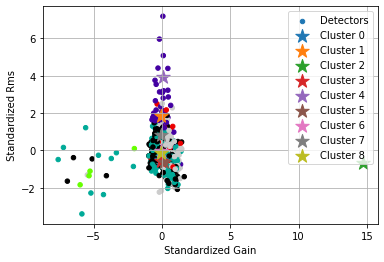

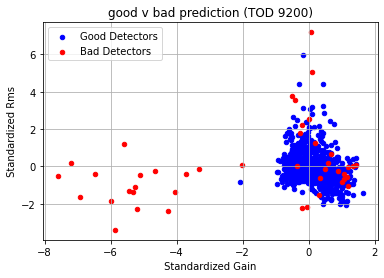

In [29]:
plt.scatter(stand_features_predict[:,0], stand_features_predict[:,1], s=20, c=pred_new, label = 'Detectors', cmap='nipy_spectral')
for i in range(n_clusters):
    plt.scatter(centers[i, 0], centers[i, 1], s = 200, label = f'Cluster {i}', marker = '*')
plt.xlabel(" Standardized Gain ")
plt.ylabel(" Standardized Rms ")
plt.legend()
plt.grid()
plt.show()

good = mask_good_predict[mask_valid_predict]

plt.scatter(stand_features_predict[:,0][good], stand_features_predict[:,1][good], s=20, c='b', label = 'Good Detectors')
plt.scatter(stand_features_predict[:,0][~good], stand_features_predict[:,1][~good], s=20, c='r', label = 'Bad Detectors')

plt.xlabel(" Standardized Gain ")
plt.ylabel(" Standardized Rms ")
plt.title('good v bad prediction (TOD 9200)')
plt.legend()
plt.grid()
plt.show()

In [30]:
TOD = np.array(['/bgfs/akosowsky/yig20/shared/pickle_files/1562165331.1562175449.ar5.pkl'])

tod9200 = load_tod_data(TOD)

cal_9200 = np.vstack([data['cal'][:,i].reshape(-1,1, order = 'F') for i in tod_predict])

tod9200 -= tod9200.mean(axis=1)[:,None]

tod9200 *= cal_9200

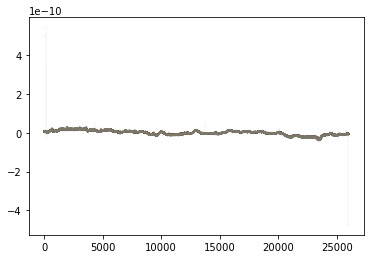

In [31]:
plt.plot(tod9200[sel_predict==1].T, alpha=0.05)
plt.show()

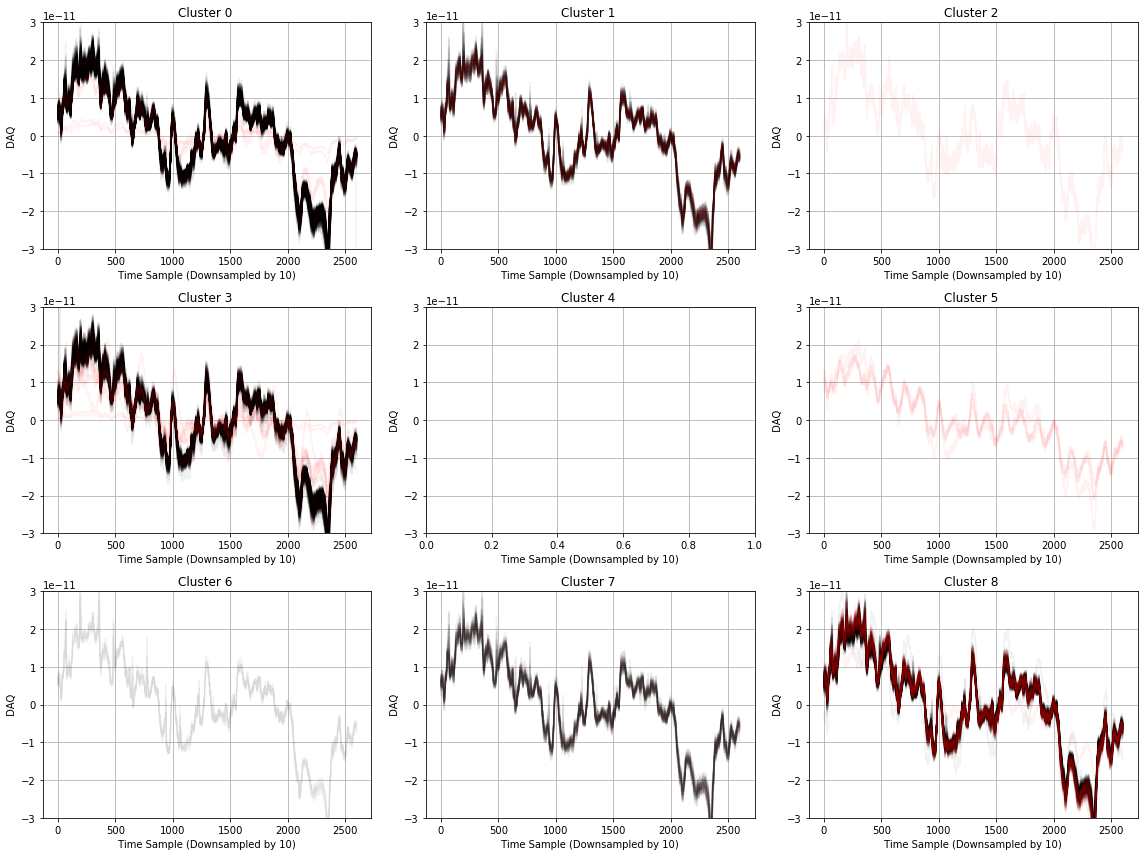

In [32]:
ncol = 3
nrow = int(np.ceil(n_clusters / 3)) 
plt.figure(figsize=(16,12))
for i in range(n_clusters):
    plt.subplot(nrow, ncol, i+1)
    # get the mask representing this cluster
    mask_pred_9200 = pred_new == i
    # get valid detectors
    det_valid_9200 = det_id_pred[mask_valid_predict]
    # get good detector mask (and valid)
    mask_sel_9200 = mask_good_predict[mask_valid_predict]
    good__ = det_valid_9200[(mask_pred_9200 * mask_sel_9200)]
    bad__ = det_valid_9200[(mask_pred_9200 * (~mask_sel_9200))]
    if len(good__) > 0: plt.plot(tod9200[good__, ::10].T, c='k', alpha=.05)
    if len(bad__) > 0: plt.plot(tod9200[bad__, ::10].T, c='r', alpha=.05)
    plt.ylim(-.3e-10,.3e-10)
    plt.grid()
    plt.ylabel(" DAQ ")
    plt.xlabel(" Time Sample (Downsampled by 10) ")
    plt.title(f"Cluster {i} ")
#plt.legend()
plt.tight_layout()
plt.show()

In [33]:
sel_list_9200=[]
det_list_9200=[]
bad_list_9200=[]


for i in range(n_clusters):
    sel_9200=np.sum(pred_new[mask_sel_9200]==i)
    sel_list_9200.append(sel_9200)
    
    det_9200=np.sum(pred_new==i)
    det_list_9200.append(det_9200)
    
    bad_9200=np.sum(pred_new==i)-np.sum(pred_new[mask_sel_9200]==i)
    bad_list_9200.append(bad_9200)
cluster = np.arange(9)
Sel_9200 = np.array(sel_list_9200)
Det_9200 = np.array(det_list_9200)
Bad_9200 = np.array(bad_list_9200)

percent_9200 = np.array((Sel_9200/Det_9200)*100)
percent_9200 = np.round(percent_9200, 2)
t = Table([cluster,Det_9200,Sel_9200,Bad_9200,percent_9200], names =( 'Cluster Number', 'Amount of Detectors','Amount of Good Detectors','Amount of Bad Detectors','Percent of Good Detectors'))

<ipython-input-33-1d00e0bfd78f>:20: RuntimeWarning: invalid value encountered in true_divide
  percent_9200 = np.array((Sel_9200/Det_9200)*100)


In [34]:
t

Cluster Number,Amount of Detectors,Amount of Good Detectors,Amount of Bad Detectors,Percent of Good Detectors
int64,int64,int64,int64,float64
0,252,247,5,98.02
1,58,53,5,91.38
2,1,0,1,0.0
3,238,227,11,95.38
4,0,0,0,nan
5,4,0,4,0.0
6,3,3,0,100.0
7,31,30,1,96.77
8,167,151,16,90.42
